<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fides

In [2]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# # 5 sources
As = np.array([0.4, 0.3,0.2,0.5,0.7])
# positions of the source
Xs = np.array([
  [-0.25,0.45],
  [-0.08,0.2],
  [-0.15,0.25],
  [0.1,-0.1],
  [0.3,0.3]
])

# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

Xd = np.array([
[ -0.2,0.6],
[0,0.6],
[0.2,0.6],
[0.4,0.6],
[0.6,0.6],
[-0.2,0.4],
[0,0.4],
[0.2,0.4],
[0.4,0.4],
[0.6,0.4],
[-0.2,0.2],
[0,0.2],
[0.2,0.2],
[0.4,0.2],
[0.6,0.2],
[-0.2,0.0],
[0,0.0],
[0.2,0.0],
[0.4,0.0],
[0.6,0.0],
[-0.2,-0.2],
[0,-0.2],
[0.2,-0.2],
[0.4,-0.2],
[0.6,-0.2],
[-0.2,-0.4],
[0,-0.4],
[0.2,-0.4],
[0.4,-0.4],
[0.6,-0.4]
])

# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [4]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


I0000 00:00:1697782032.507303   21179 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [5]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 7,
    nsim = 100
)

res = green_opt(
    t,
    observations,
    opt_case='tr_optimizer',
    opt_options = {
        'maxiter': 1500,
        'xtol': 1e-6,
        'fatol': 1e-10,
        'stepback_strategy': 'truncate',
    }
)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 21.171101093292236 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 13.52848768234253 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 19.93186593055725 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 23.17924690246582 SECONDS
SIMULATIONS FOR 5 SOURCES TOOK 198.1811625957489 SECONDS
SIMULATIONS FOR 6 SOURCES TOOK 169.1055178642273 SECONDS
SIMULATIONS FOR 7 SOURCES TOOK 114.14119410514832 SECONDS
Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [6]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1.323364e+04,1.000000,1.000000,9.663678,"[1.4999964401687478, 0.01696260093393896, 0.25..."
0,2,-1.573194e+04,1.000000,1.000000,3.409561,"[[0.7656108183961271, 1.25366526598914], [0.19..."
0,3,-1.802936e+04,1.000000,1.000000,1.307990,"[[0.923345900696109, 0.5184869668781131, 0.461..."
0,4,-2.836968e+04,1.000000,1.000000,0.017583,"[[0.48746242535599904, 0.4114759316363317, 0.7..."
0,5,-3.286914e+04,0.997159,0.986175,0.002695,"[[0.19510060893747305, 0.3052551396361754, 0.7..."
0,6,-3.287116e+04,0.734191,-0.033874,0.002690,"[[0.3993906999706939, 0.6619268556376693, 0.19..."
0,7,inf,0.351397,-0.418035,0.002719,"[[0.3643321489967537, 0.41844511165991105, 0.1..."


In [7]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

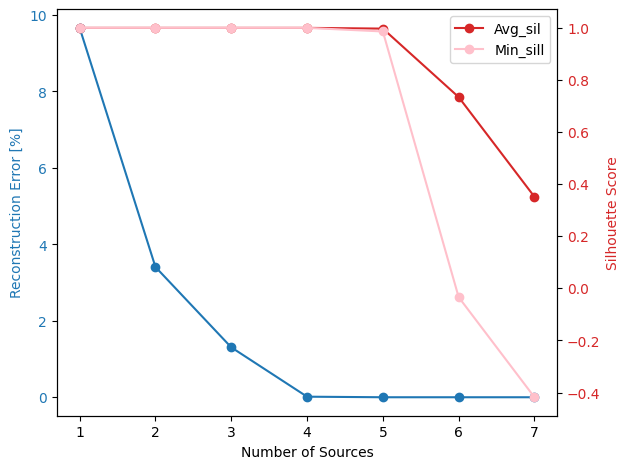

In [8]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [9]:
Forclusts['centers'].iloc[4]

array([[ 0.19510061,  0.30525514,  0.70001145,  0.39965719,  0.49998251],
       [-0.15113652, -0.08059127,  0.29999272, -0.25001247,  0.1000034 ],
       [ 0.25111876,  0.20027729,  0.29999611,  0.45007162, -0.1000075 ],
       [ 0.05000024,  0.05000024,  0.05000024,  0.05000024,  0.05000024],
       [ 0.00500004,  0.00500004,  0.00500004,  0.00500004,  0.00500004],
       [ 0.00125   ,  0.00125   ,  0.00125   ,  0.00125   ,  0.00125   ]])

In [10]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.4 ,  0.3 ,  0.2 ,  0.5 ,  0.7 ],
       [-0.25, -0.08, -0.15,  0.1 ,  0.3 ],
       [ 0.45,  0.2 ,  0.25, -0.1 ,  0.3 ]])